In [399]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib as plt
import seaborn as sns
import warnings
from pylab import rcParams
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 6, 4

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [290]:
data = pd.read_csv(r'C:\Users\user\Desktop\Kurs_project_task\train.csv')

In [23]:
train, valid = train_test_split(data, test_size=0.2, random_state=42)

In [24]:
data.shape

(10000, 20)

In [25]:
train.shape

(8000, 20)

In [26]:
valid.shape

(2000, 20)

In [27]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9254,12473,58,1.0,65.271225,62.798045,1.0,3,1.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,210849.693542
1561,14050,146,2.0,45.091598,43.816601,1.0,5,18.0,2017,0.236108,B,B,16,3893,27,NaN,3,10,B,201549.998077
1670,3779,5,1.0,34.463114,20.561823,5.0,3,5.0,1960,0.150818,B,B,16,3433,4,2643.0,4,5,B,158433.168775
6087,3762,90,3.0,61.931107,46.126389,5.0,4,5.0,1966,0.265089,B,B,37,5288,0,1937.0,3,2,B,220194.818430
6669,358,1,1.0,42.670840,NaN,1.0,8,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,125834.270291


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 9254 to 7270
Data columns (total 20 columns):
Id               8000 non-null int64
DistrictId       8000 non-null int64
Rooms            8000 non-null float64
Square           8000 non-null float64
LifeSquare       6299 non-null float64
KitchenSquare    8000 non-null float64
Floor            8000 non-null int64
HouseFloor       8000 non-null float64
HouseYear        8000 non-null int64
Ecology_1        8000 non-null float64
Ecology_2        8000 non-null object
Ecology_3        8000 non-null object
Social_1         8000 non-null int64
Social_2         8000 non-null int64
Social_3         8000 non-null int64
Healthcare_1     4148 non-null float64
Helthcare_2      8000 non-null int64
Shops_1          8000 non-null int64
Shops_2          8000 non-null object
Price            8000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.3+ MB


In [29]:
import sys
!{sys.executable} -m pip install pandas-profiling

In [31]:
import pandas_profiling
pandas_profiling.ProfileReport(train)

In [32]:
mean_year = np.round(train.loc[train['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1985.0

In [36]:
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [43]:
def clean_objects(df):
    object_map = {
        "A": 0, "B": 1 
    }
    df["Shops_2"] = df["Shops_2"].map(object_map)
    df["Ecology_2"] = df["Ecology_2"].map(object_map)
    df["Ecology_3"] = df["Ecology_3"].map(object_map)

In [44]:
def clean_life_square(df):
    df.loc[(df['LifeSquare'] < 5) | (df['LifeSquare'].isnull()), 'LifeSquare'] = df['Square']*0.85

In [372]:
def clean_kitchen(df):
    df.loc[(df['KitchenSquare'] < 5) | (df['KitchenSquare'] > 25), 'KitchenSquare'] = df['KitchenSquare'].mean()

In [373]:
def prepare_data(df, mean_year=mean_year):
    clean_year(df, mean_year)
    clean_life_square(df)
    clean_objects(df)
    clean_kitchen(df)

In [374]:
prepare_data(train)
prepare_data(valid)

In [375]:
feats = ['DistrictId', 'Ecology_1', 'Floor', 'Square', 'LifeSquare', 'Rooms', 'HouseYear', 'Social_3', 'HouseFloor', 'KitchenSquare']

In [413]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42,criterion='mse')

In [414]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [415]:
pred_train = model.predict(train.loc[:, feats])

In [416]:
r2(train['Price'], pred_train)

0.867301245601748

In [417]:
pred_valid = model.predict(valid.loc[:, feats])

In [418]:
r2(valid['Price'], pred_valid)

0.7049527870553787

In [419]:
max_depth_grid = np.arange(2, 24)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate (max_depth_grid):
    model = RandomForestRegressor(n_estimators=100, max_depth=value, random_state=42,criterion='mse')
    
    model.fit(train.loc[:, feats], train['Price'])
    pred_train = model.predict(train.loc[:, feats])
    acc_train = r2(train['Price'], pred_train)
    pred_valid = model.predict(valid.loc[:, feats])
    acc_valid = r2(valid['Price'], pred_valid)
    if i % 1 == 0:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)
    
     

K = 2
	acc_valid = 0.3906267514957483
	acc_train = 0.42302938822771885

K = 3
	acc_valid = 0.482491625938814
	acc_train = 0.5162811036413447

K = 4
	acc_valid = 0.5580457568633181
	acc_train = 0.5967678421025027

K = 5
	acc_valid = 0.6116552707485903
	acc_train = 0.6630483622192263

K = 6
	acc_valid = 0.6529356229102705
	acc_train = 0.7210767717213034

K = 7
	acc_valid = 0.6775197856148312
	acc_train = 0.7675779877491837

K = 8
	acc_valid = 0.6912900459609688
	acc_train = 0.805742743177322

K = 9
	acc_valid = 0.6999475759756055
	acc_train = 0.8392111279492078

K = 10
	acc_valid = 0.7049527870553787
	acc_train = 0.867301245601748

K = 11
	acc_valid = 0.7091640737394285
	acc_train = 0.8909844736765904

K = 12
	acc_valid = 0.7093593474480804
	acc_train = 0.9102948699203175

K = 13
	acc_valid = 0.7086292504281131
	acc_train = 0.9256994144694003

K = 14
	acc_valid = 0.7082741312412937
	acc_train = 0.9376922827661807

K = 15
	acc_valid = 0.7104032210566642
	acc_train = 0.9459087185959164

K 

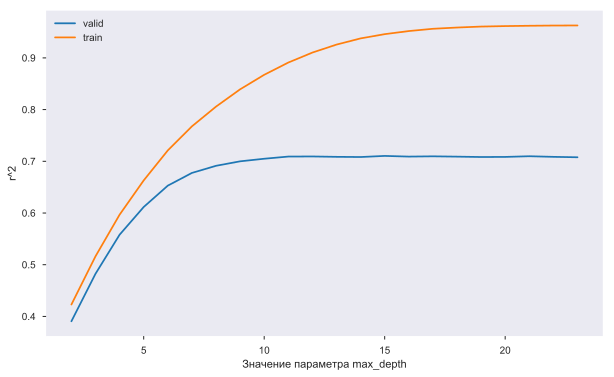

In [420]:
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(max_depth_grid, accuracy_on_valid, label="valid")
plt.plot(max_depth_grid, accuracy_on_train, label="train")

plt.xlabel('Значение параметра max_depth')
plt.ylabel('r^2')

plt.legend()
plt.grid()

plt.show()

prediction RendomForestRegressor

In [364]:
test = pd.read_csv(r'C:\Users\user\Desktop\Kurs_project_task\test.csv')

In [365]:
test.shape

(5000, 19)

In [366]:
prepare_data(test)

In [367]:
test['Price'] = model.predict(test.loc[:, feats])

In [368]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972.0,0.310199,1,1,11,2748,1,NaN,0,0,1,165418.444655
1,15856,74,2.0,69.263183,58.873706,1.0,6,1.0,1977.0,0.075779,1,1,6,1437,3,NaN,0,2,1,227486.432175
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909.0,0.000000,1,1,30,7538,87,4702.0,5,5,1,211913.510138
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007.0,0.101872,1,1,23,4583,3,NaN,3,3,1,334709.663407
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017.0,0.072158,1,1,2,629,1,NaN,0,0,0,148579.578546


In [369]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null float64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null int64
Ecology_3        5000 non-null int64
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null int64
Price            5000 non-null float64
dtypes: float64(9), int64(11)
memory usage: 781.3 KB


In [370]:
pandas_profiling.ProfileReport(test)

In [5]:
test.loc[:, ['Id', 'Price']].to_csv('DLetyuk_predictions.csv', index=False)